In [44]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option('display.max_columns', None)

In [45]:
df = pd.read_excel("OnlineRetail.xlsx")

In [46]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [48]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [49]:
df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [50]:
df.isnull().any(axis=1).sum() 

135080

In [51]:
NumCols = df.select_dtypes(include='number')
CatCols = df.select_dtypes(exclude='number')

In [52]:
for num_col in NumCols.columns:
    df[num_col].fillna(df[num_col].mean(), inplace=True)

for cat_col in CatCols.columns:
    df[cat_col].fillna(df[cat_col].mode()[0], inplace=True)
    
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [53]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate the total spending for each transaction
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

# Calculate the recency of purchase for each customer
max_date = df['InvoiceDate'].max()
df['Recency'] = max_date - df.groupby('CustomerID')['InvoiceDate'].transform('max')

# Convert to the number of days
df['Recency'] = df['Recency'].dt.days  

# Calculate the order frequency for each customer
df['OrderFrequency'] = df.groupby('CustomerID')['InvoiceNo'].transform('nunique')

# Calculate the average basket size for each customer
df['BasketSize'] = df.groupby(['CustomerID', 'InvoiceNo'])['Quantity'].transform('sum')
df = df.drop_duplicates(subset=['CustomerID', 'InvoiceNo'])  

# Group data by CustomerID to obtain customer-level features
df = df.groupby('CustomerID').agg({
    'Recency': 'min',
    'OrderFrequency': 'mean',
    'TotalSpending': 'sum',
    'BasketSize': 'mean'
}).reset_index()

#df = df.drop(['Description', 'Country'], axis=1)

df.head(5)

,CustomerID,Recency,OrderFrequency,TotalSpending,BasketSize
0,12346.0,325,2.0,0.00,0.000000
1,12347.0,1,7.0,163.16,351.142857
2,12348.0,74,4.0,331.36,585.250000
3,12349.0,18,1.0,15.00,631.000000
4,12350.0,309,1.0,25.20,197.000000


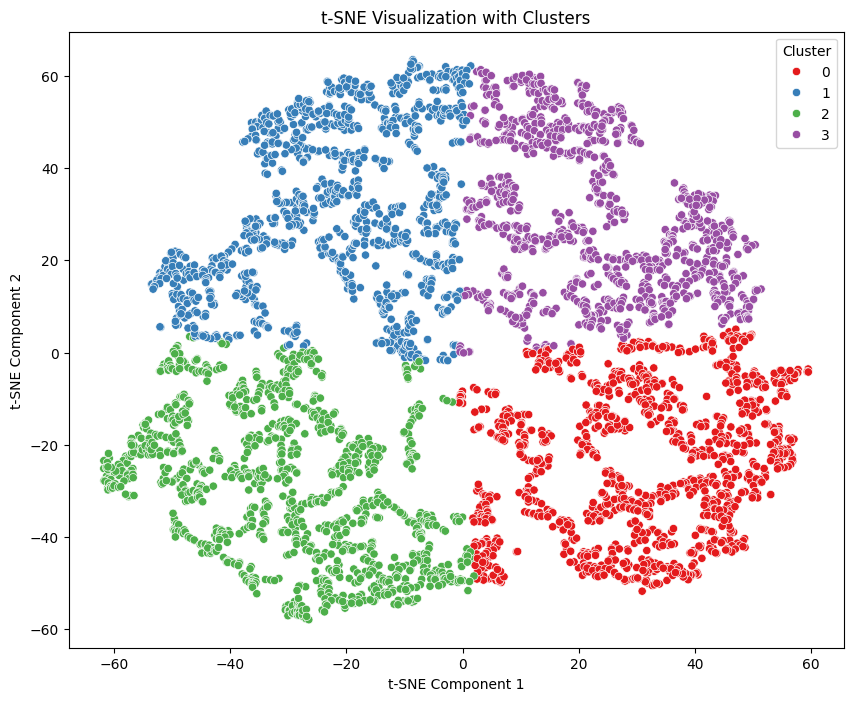

In [54]:
num_cols = df.select_dtypes(include='number')

# Standardize numerical features for PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(num_cols)

# Apply PCA to reduce dimensionality while retaining important features
pca = PCA(n_components=min(num_cols.shape[0], num_cols.shape[1]))
pca_result = pca.fit_transform(scaled_data)

# Add PCA results to the DataFrame
for i in range(pca_result.shape[1]):
    df[f'PCA_Component_{i+1}'] = pca_result[:, i]

# Apply t-SNE on the PCA-reduced feature space
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)
df['t-SNE_Component_1'] = tsne_result[:, 0]
df['t-SNE_Component_2'] = tsne_result[:, 1]

# Define the number of clusters (4 clusters)
K = 4

# Explicitly set the value of 'n_init'
kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)

# Perform K-means clustering on the t-SNE-reduced feature space
df['Cluster'] = kmeans.fit_predict(tsne_result)

# Create a scatter plot of the t-SNE result with cluster coloring
plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE_Component_1', y='t-SNE_Component_2', hue='Cluster', data=df, palette='Set1')
plt.title('t-SNE Visualization with Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [55]:
# Calculate cluster-specific metrics
cluster_metrics = df.groupby('Cluster').agg({
    'Recency': 'mean',            
    'OrderFrequency': 'mean',    
    'TotalSpending': 'mean',     
    'BasketSize': 'mean',        
}).reset_index()

# Rename the columns for clarity
cluster_metrics.columns = ['Cluster', 'AvgRecency', 'AvgPurchaseFrequency', 'AvgSpending', 'AvgBasketSize']

# Print or display the cluster metrics
print(cluster_metrics)

   Cluster  AvgRecency  AvgPurchaseFrequency  AvgSpending  AvgBasketSize
0        0   44.613322              5.395329   166.475848     178.053103
1        1   40.886845             10.324747   135.698105     257.678523
2        2  238.665508              2.022589    77.434283     183.527438
3        3   27.923391              6.243105   161.611726     166.849583


In [56]:
distinguishing_characteristics = {}

for cluster in range(len(cluster_metrics)):
    cluster_row = cluster_metrics.iloc[cluster]
    cluster_num = cluster_row['Cluster']
    cluster_name = f"Cluster {int(cluster_num)}"
    
    highest_value_column = cluster_row[1:].idxmax()  
    highest_value = cluster_row[highest_value_column]  
    
    distinguishing_characteristics[cluster_name] = {
        'Characteristic': highest_value_column,
        'HighestValue': highest_value
    }

# Print the distinguishing characteristics for each cluster
for cluster, char_info in distinguishing_characteristics.items():
    print(f"{cluster} has the highest {char_info['Characteristic']} ({char_info['HighestValue']}).")

Cluster 0 has the highest AvgBasketSize (178.05310289570434).
Cluster 1 has the highest AvgBasketSize (257.67852272079733).
Cluster 2 has the highest AvgRecency (238.66550825369245).
Cluster 3 has the highest AvgBasketSize (166.84958302376776).


In [57]:
unique_features = {}

for cluster in range(len(cluster_metrics)):
    if cluster == 1:
        continue  # Skip Cluster 1
        
    cluster_row = cluster_metrics.iloc[cluster]
    cluster_num = cluster_row['Cluster']
    cluster_name = f"Cluster {int(cluster_num)}"
    
    unique_features[cluster_name] = {
        'Recency': cluster_metrics.loc[1, 'AvgRecency'] - cluster_row['AvgRecency'],
        'PurchaseFrequency': cluster_metrics.loc[1, 'AvgPurchaseFrequency'] - cluster_row['AvgPurchaseFrequency'],
        'Spending': cluster_metrics.loc[1, 'AvgSpending'] - cluster_row['AvgSpending'],
        'BasketSize': cluster_metrics.loc[1, 'AvgBasketSize'] - cluster_row['AvgBasketSize']
    }

# Print the unique features for Cluster 1 compared to other clusters
for cluster, unique_info in unique_features.items():
    print(f"{cluster} has unique features compared to Cluster 1:")
    print(f"   -  Recency: {unique_info['Recency']:.2f}")
    print(f"   -  Purchase Frequency: {unique_info['PurchaseFrequency']:.2f}")
    print(f"   -  Spending: {unique_info['Spending']:.2f}")
    print(f"   -  Basket Size: {unique_info['BasketSize']:.2f}")

Cluster 0 has unique features compared to Cluster 1:
   -  Recency: -3.73
   -  Purchase Frequency: 4.93
   -  Spending: -30.78
   -  Basket Size: 79.63
Cluster 2 has unique features compared to Cluster 1:
   -  Recency: -197.78
   -  Purchase Frequency: 8.30
   -  Spending: 58.26
   -  Basket Size: 74.15
Cluster 3 has unique features compared to Cluster 1:
   -  Recency: 12.96
   -  Purchase Frequency: 4.08
   -  Spending: -25.91
   -  Basket Size: 90.83


C:\Users\anaal\AppData\Local\Temp\ipykernel_20756\2001285713.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='AvgRecency', data=cluster_metrics, palette='Set1')


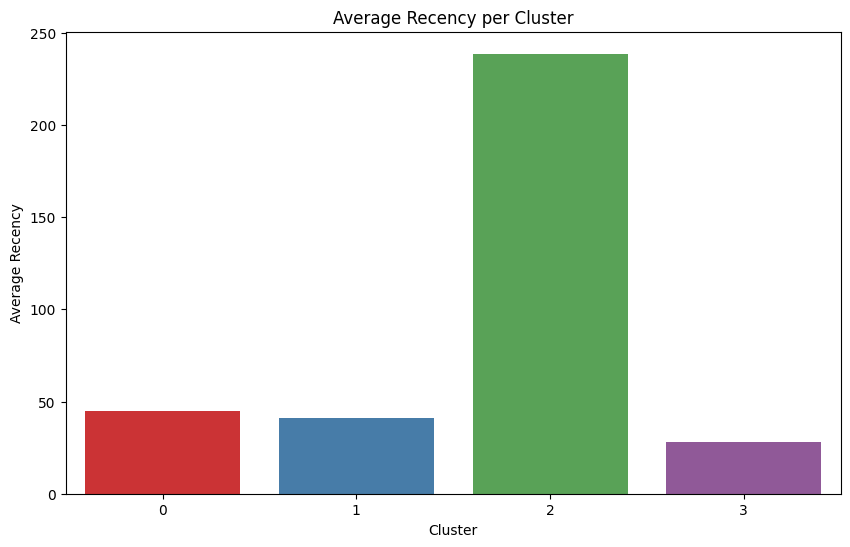

In [58]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgRecency', data=cluster_metrics, palette='Set1')
plt.title('Average Recency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Recency')
plt.show()

C:\Users\anaal\AppData\Local\Temp\ipykernel_20756\59678642.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='AvgPurchaseFrequency', data=cluster_metrics, palette='Set1')


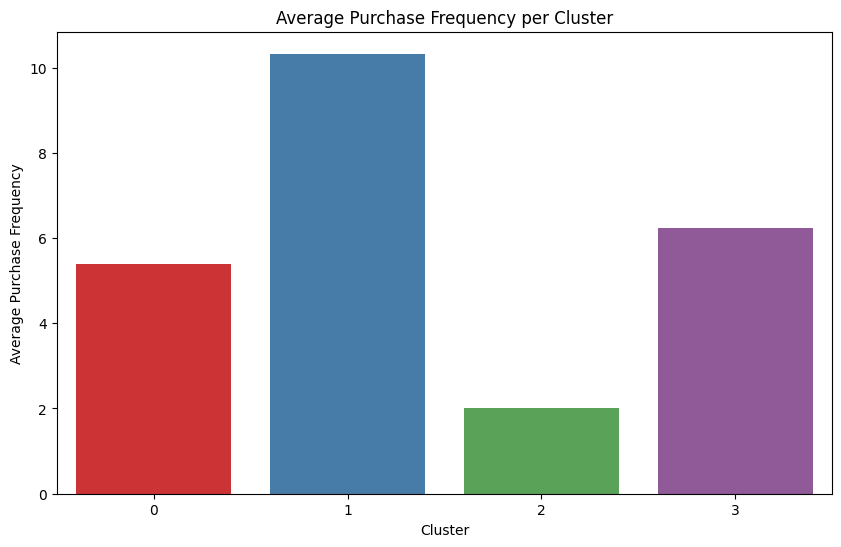

In [59]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgPurchaseFrequency', data=cluster_metrics, palette='Set1')
plt.title('Average Purchase Frequency per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Purchase Frequency')
plt.show()

C:\Users\anaal\AppData\Local\Temp\ipykernel_20756\3153253939.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='AvgSpending', data=cluster_metrics, palette='Set1')


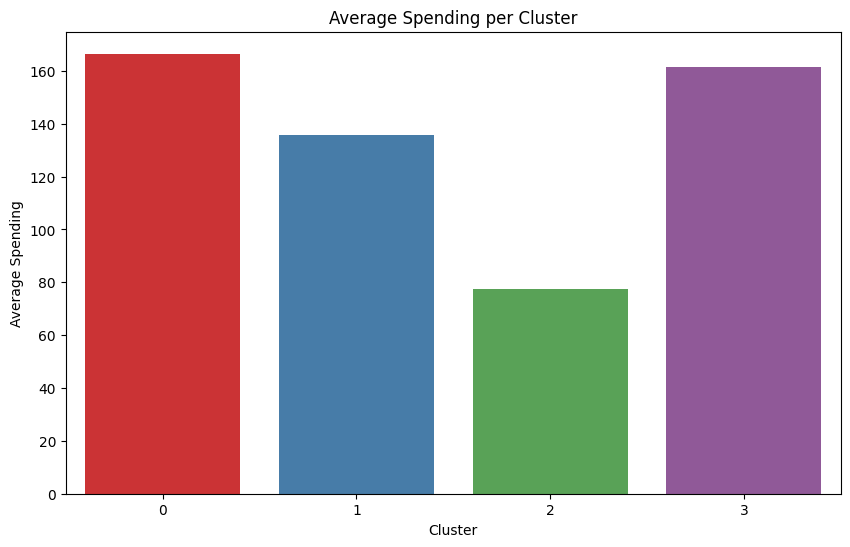

In [60]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgSpending', data=cluster_metrics, palette='Set1')
plt.title('Average Spending per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spending')
plt.show()

C:\Users\anaal\AppData\Local\Temp\ipykernel_20756\3833023689.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='AvgBasketSize', data=cluster_metrics, palette='Set1')


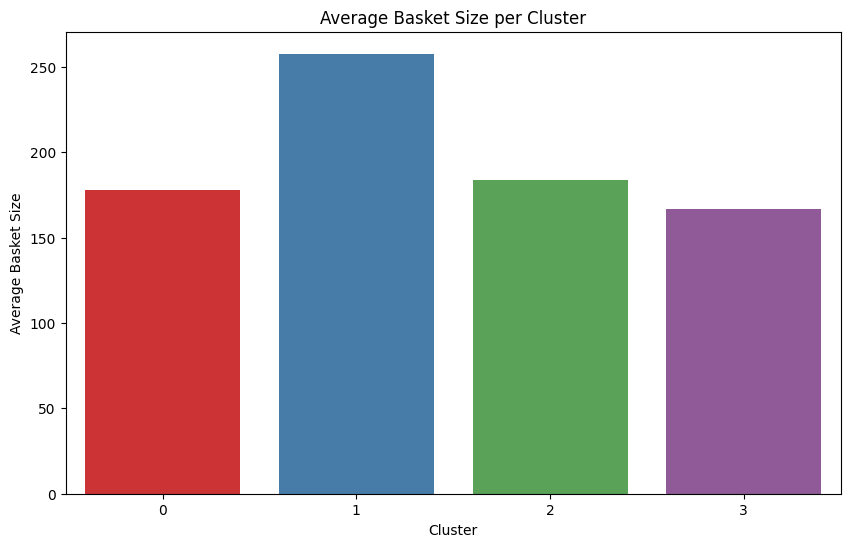

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='AvgBasketSize', data=cluster_metrics, palette='Set1')
plt.title('Average Basket Size per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Basket Size')
plt.show()

For K=2:
  - Silhouette Score: 0.37
  - WCSS: 5327316.50
For K=3:
  - Silhouette Score: 0.44
  - WCSS: 2850793.00
For K=4:
  - Silhouette Score: 0.40
  - WCSS: 2146488.00
For K=5:
  - Silhouette Score: 0.39
  - WCSS: 1674477.50
For K=6:
  - Silhouette Score: 0.38
  - WCSS: 1382213.62
For K=7:
  - Silhouette Score: 0.40
  - WCSS: 1159497.12
For K=8:
  - Silhouette Score: 0.40
  - WCSS: 990932.56
For K=9:
  - Silhouette Score: 0.39
  - WCSS: 865173.56
For K=10:
  - Silhouette Score: 0.40
  - WCSS: 767428.94


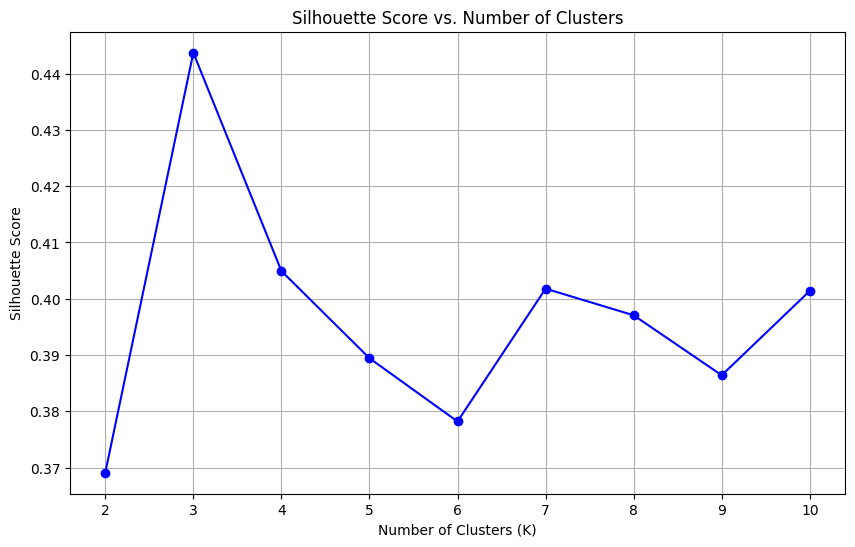

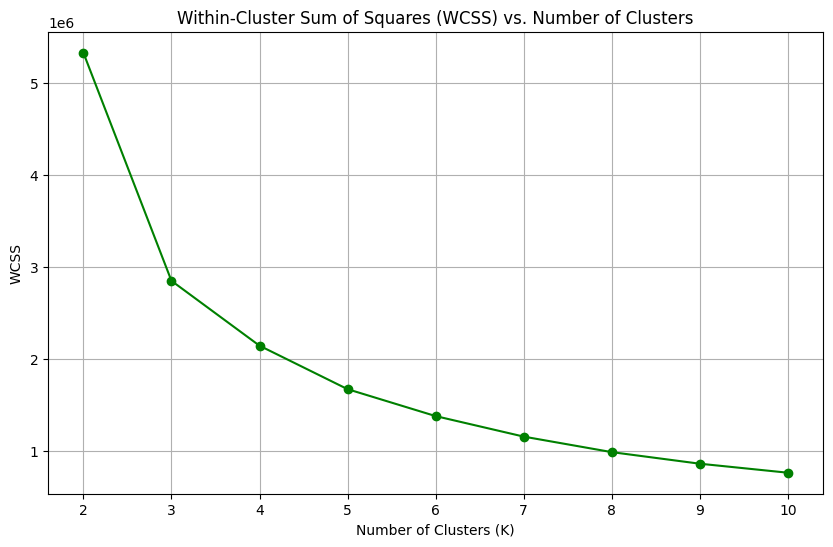

In [62]:
silhouette_scores = []
wcss = []

# Create a range of K values to try
K_range = range(2, 11)

for K in K_range:
    # Fit K-means clustering for each K
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(tsne_result)  # Use t-SNE result for clustering
    
    # Calculate the silhouette score for the current K
    silhouette_avg = silhouette_score(tsne_result, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

    # Calculate the within-cluster sum of squares (WCSS)
    wcss.append(kmeans.inertia_)
    
    print(f"For K={K}:")
    print(f"  - Silhouette Score: {silhouette_avg:.2f}")
    print(f"  - WCSS: {wcss[-1]:.2f}")

# Plot the silhouette scores to visualize the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='b')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Plot the WCSS to find the "elbow point" for choosing K
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='g')
plt.title('Within-Cluster Sum of Squares (WCSS) vs. Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [63]:
from sklearn.metrics import pairwise_distances

# Calculate the pairwise distances between data points in the t-SNE-reduced space
pairwise_dist = pairwise_distances(tsne_result)
total_cohesion = 0
total_separation = 0

# Iterate through each cluster
for cluster in range(K):
    cluster_indices = np.where(kmeans.labels_ == cluster)[0]

    # Calculate cohesion for the current cluster
    cohesion = np.mean(pairwise_dist[cluster_indices][:, cluster_indices])
    total_cohesion += cohesion

    # Calculate separation for the current cluster
    other_clusters_indices = np.where(kmeans.labels_ != cluster)[0]
    separation = np.mean(pairwise_dist[cluster_indices][:, other_clusters_indices])
    total_separation += separation

average_cohesion = total_cohesion / K
average_separation = total_separation / K

# Print or display the cohesion and separation metrics
print(f"Average Cohesion: {average_cohesion:.2f}")
print(f"Average Separation: {average_separation:.2f}")

Average Cohesion: 16.59
Average Separation: 61.60
